In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('housing.csv')
len(df)

20640

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [5]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,near_bay
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,near_bay
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,near_bay
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,near_bay
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,near_bay


## Exploratory data analysis

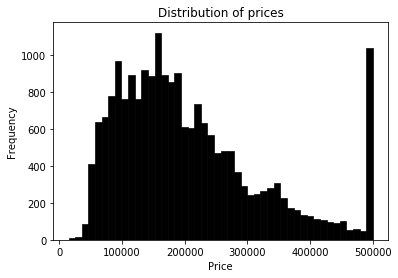

In [8]:
plt.figure(figsize=(6, 4))

sns.histplot(df.median_house_value, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

In [9]:
df = df.drop('ocean_proximity', axis=1)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


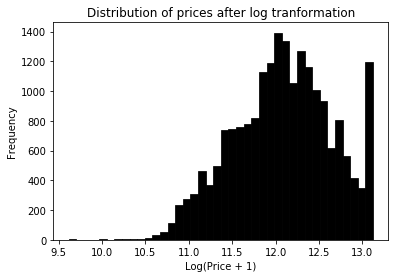

In [10]:
log_price = np.log1p(df.median_house_value)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

In [11]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [13]:
df['population'].median()

1166.0

## Validation framework

In [14]:
np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [15]:
y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

## Linear Regression

In [16]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

## Baseline solution (fill NAs with 0)

In [19]:
def prepare_X_zeros(dframe):
    dframe = dframe.fillna(0)
    X = dframe.values
    return X

In [20]:
X_train_zeros = prepare_X_zeros(df_train)
w_0_zeros, w_zeros = train_linear_regression(X_train_zeros, y_train)

In [21]:
y_pred_zeros = w_0_zeros + X_train_zeros.dot(w_zeros)

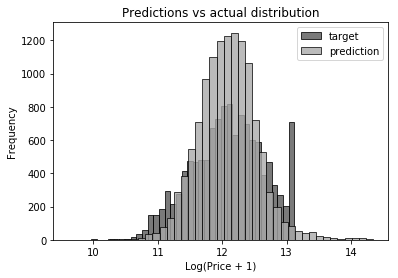

In [22]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred_zeros, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

## Baseline solution (fill NAs with means)

In [23]:
def prepare_X_means(dframe):
    dframe = dframe.fillna(df_train.mean())
    X = dframe.values
    return X

In [24]:
X_train_means = prepare_X_means(df_train)
w_0_means, w_means = train_linear_regression(X_train_means, y_train)

In [25]:
y_pred_means = w_0_means + X_train_means.dot(w_means)

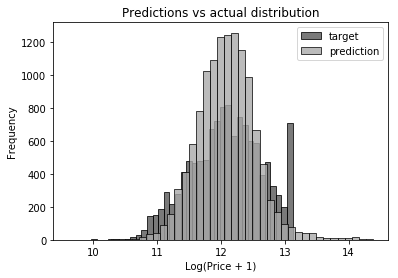

In [26]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred_means, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

## Comparing RMSEs

In [36]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return round(np.sqrt(mse), 2)

In [37]:
rmse(y_train, y_pred_zeros)

0.34

In [38]:
rmse(y_train, y_pred_means)

0.34

In [40]:
X_val = prepare_X_means(df_val)
y_pred = w_0_means + X_val.dot(w_means)

In [41]:
rmse(y_val, y_pred)

0.33

## Simple feature engineering

In [22]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [23]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation', rmse(y_val, y_pred))

train 0.5175055465840046
validation 0.5172055461058335


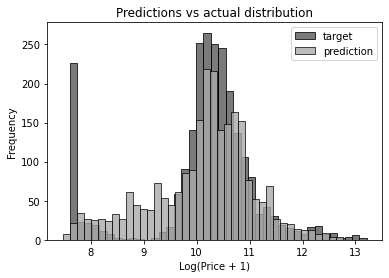

In [24]:
plt.figure(figsize=(6, 4))


sns.histplot(y_val, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [25]:
df['make'].value_counts().head(5)

chevrolet     1123
ford           881
volkswagen     809
toyota         746
dodge          626
Name: make, dtype: int64

In [26]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [27]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

train: 0.5058876515487503
validation: 0.5076038849557035


In [28]:
df['engine_fuel_type'].value_counts()

regular_unleaded                                7172
premium_unleaded_(required)                     2009
premium_unleaded_(recommended)                  1523
flex-fuel_(unleaded/e85)                         899
diesel                                           154
electric                                          66
flex-fuel_(premium_unleaded_required/e85)         54
flex-fuel_(premium_unleaded_recommended/e85)      26
flex-fuel_(unleaded/natural_gas)                   6
natural_gas                                        2
Name: engine_fuel_type, dtype: int64

In [29]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in ['regular_unleaded', 'premium_unleaded_(required)', 
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)
        
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [30]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

train: 0.4788482615078598
validation: 0.4748256737227088


In [31]:
df['transmission_type'].value_counts()

automatic           8266
manual              2935
automated_manual     626
direct_drive          68
unknown               19
Name: transmission_type, dtype: int64

In [32]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in ['regular_unleaded', 'premium_unleaded_(required)', 
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)

    for v in ['automatic', 'manual', 'automated_manual']:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)
        
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [33]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

train: 0.4745380510924004
validation: 0.4685879194659198


In [34]:
df['driven_wheels'].value_counts()

front_wheel_drive    4787
rear_wheel_drive     3371
all_wheel_drive      2353
four_wheel_drive     1403
Name: driven_wheels, dtype: int64

In [35]:
df['market_category'].value_counts().head(5)

crossover             1110
flex_fuel              872
luxury                 855
luxury,performance     673
hatchback              641
Name: market_category, dtype: int64

In [36]:
df['vehicle_size'].value_counts().head(5)

compact    4764
midsize    4373
large      2777
Name: vehicle_size, dtype: int64

In [37]:
df['vehicle_style'].value_counts().head(5)

sedan            3048
4dr_suv          2488
coupe            1211
convertible       793
4dr_hatchback     702
Name: vehicle_style, dtype: int64

In [38]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in ['regular_unleaded', 'premium_unleaded_(required)', 
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)

    for v in ['automatic', 'manual', 'automated_manual']:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)

    for v in ['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive']:
        feature = 'is_driven_wheens_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)

    for v in ['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback']:
        feature = 'is_mc_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)

    for v in ['compact', 'midsize', 'large']:
        feature = 'is_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)

    for v in ['sedan', '4dr_suv', 'coupe', 'convertible', '4dr_hatchback']:
        feature = 'is_style_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [39]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

train: 1607.4898641126447
validation: 830.8920785817741


In [40]:
w_0

-6.947006956027172e+17

## Regularization

In [42]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [43]:
X_train = prepare_X_zeros(df_train)

In [48]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    print('%5s, %.2f, %.2f' % (r, w_0, w[1]))

    0, -11.69, -0.28
1e-06, -11.69, -0.28
0.0001, -11.69, -0.28
0.001, -11.67, -0.28
 0.01, -11.53, -0.28
  0.1, -10.27, -0.27
    1, -4.92, -0.22
    5, -1.48, -0.18
   10, -0.79, -0.18


In [50]:
X_train = prepare_X_zeros(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0)

y_pred = w_0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val = prepare_X_zeros(df_val)
y_pred = w_0 + X_val.dot(w)
print('val', rmse(y_val, y_pred))

train 0.34
val 0.33


In [51]:
X_train = prepare_X_zeros(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

y_pred = w_0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val = prepare_X_zeros(df_val)
y_pred = w_0 + X_val.dot(w)
print('val', rmse(y_val, y_pred))

train 0.34
val 0.33


In [52]:
X_train = prepare_X_zeros(df_train)
X_val = prepare_X_zeros(df_val)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred))

     0 0.33
 1e-06 0.33
0.0001 0.33
 0.001 0.33
  0.01 0.33
   0.1 0.33
     1 0.33
     5 0.34
    10 0.34


In [53]:
X_train = prepare_X_zeros(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X_zeros(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

X_test = prepare_X_zeros(df_test)
y_pred = w_0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))

validation: 0.33
test: 0.35


## Using the model

In [48]:
i = 2
ad = df_test.iloc[i].to_dict()
ad

{'make': 'toyota',
 'model': 'venza',
 'year': 2013,
 'engine_fuel_type': 'regular_unleaded',
 'engine_hp': 268.0,
 'engine_cylinders': 6.0,
 'transmission_type': 'automatic',
 'driven_wheels': 'all_wheel_drive',
 'number_of_doors': 4.0,
 'market_category': 'crossover,performance',
 'vehicle_size': 'midsize',
 'vehicle_style': 'wagon',
 'highway_mpg': 25,
 'city_mpg': 18,
 'popularity': 2031}

In [49]:
X_test = prepare_X(pd.DataFrame([ad]))[0]
y_pred = w_0 + X_test.dot(w)
suggestion = np.expm1(y_pred)
suggestion

28294.135912260714